<a href="https://colab.research.google.com/github/wrodemoyer/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Product Sales**



- **Author:** William Rodemoyer

## Project Overview

## Data Dictionary

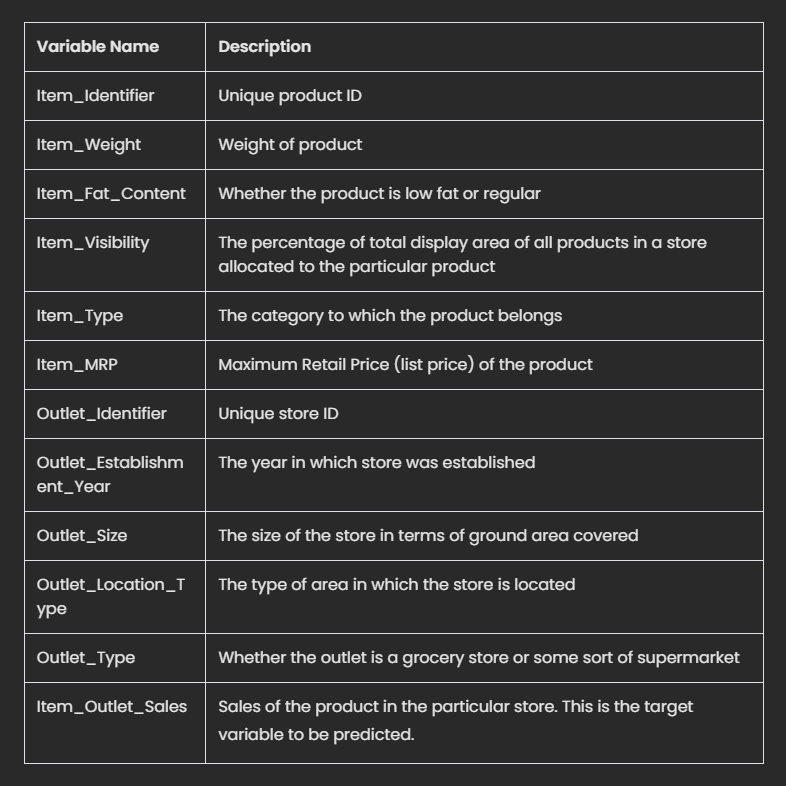

## Imports

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
# Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
# setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

## Load and Inspect Data

In [88]:
df = pd.read_csv('Data/sales_predictions_2023.csv')


### .head()

In [89]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### .info()

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### .shape

In [91]:
# Identifying how many rows and columns.
df.shape 


(8523, 12)

The dataframe has 8523 rows, and 12 columns.

### .dtypes

In [92]:
# Identifying each variables datatype.
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

## Clean Data

### Duplicates

In [93]:
# Checking for duplicates.
df.duplicated().sum()

0

There are ***Zero*** duplicates. 

### Missing Values

In [94]:
# Identifying any missing values.
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

'Item_Weight' has 1463 missing values, and 'Outlet_Size' has 2410 missing values.

In [95]:
# Finding the percentage of missing values in each column.
print(df.isna().sum()/len(df)*100)

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64


In [96]:
# Resolving the missing values in column 'Item_Weight' 
median_weight = df['Item_Weight'].median()

In [97]:
df['Item_Weight'].fillna( value = median_weight, inplace= True)

I decided to Impute missing values using the 'median' value of the column because this is less affected by outliers than using the 'mean'. 

In [98]:
# Resolving the missing values in column 'Outlet_Size'
df['Outlet_Size'].fillna( value = 'Unknown', inplace= True)

I decided to replace missing values with the value 'Unknown' because this typically will not create bias in favor of a specific label or class.

In [99]:
# Confirming that all missing values were dealt with.
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

There are now ***Zero*** missing values. 

## Identifying any Inconsistencies in Data

### Numeric Columns

In [100]:
# Retrieving the min, max, & mean of any numeric column.
df.describe(include= 'number')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.81342,0.066132,140.992782,1997.831867,2181.288914
std,4.22724,0.051598,62.275067,8.371760,1706.499616
min,4.55500,0.000000,31.290000,1985.000000,33.290000
25%,9.31000,0.026989,93.826500,1987.000000,834.247400
50%,12.60000,0.053931,143.012800,1999.000000,1794.331000
75%,16.00000,0.094585,185.643700,2004.000000,3101.296400
max,21.35000,0.328391,266.888400,2009.000000,13086.964800


- No inconsistencies noted.

Min, Max, and Mean for each Numerical Column.

---
'Item_Weight'

*   min: 4.55500
*   max: 21.35000	
*   mean: 12.81342	


'Item_Visibility'

*   min:  0.000000
*   max:  0.328391	
*   mean: 0.066132

'Item_MRP'
*   min: 31.290000	
*   max:  266.888400	
*   mean: 140.992782	

'Outlet_Establishment_Year'


*   min: 1985.000000	
*   max: 2009.000000	
*   mean: 1997.831867	

'Item_Outlet_Sales'
*   min: 33.290000
*   max: 13086.964800
*   mean: 2181.288914













#### Item Weight Column

In [101]:
df['Item_Weight'].describe()

count    8523.00000
mean       12.81342
std         4.22724
min         4.55500
25%         9.31000
50%        12.60000
75%        16.00000
max        21.35000
Name: Item_Weight, dtype: float64

#### Item Visibility Column

In [102]:
df['Item_Visibility'].describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

#### Item MRP Column

In [103]:
df['Item_MRP'].describe()

count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64

#### Item Outlet Sales Column

In [104]:
df['Item_Outlet_Sales'].describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

- All numeric columns look good

### Categorical Columns

In [105]:
# Creating a filter to help display any unique values
dtypes = df.dtypes
obj_col = dtypes[dtypes == 'object']
obj_col

Item_Identifier         object
Item_Fat_Content        object
Item_Type               object
Outlet_Identifier       object
Outlet_Size             object
Outlet_Location_Type    object
Outlet_Type             object
dtype: object

#### Item Identifier Column

In [106]:
print(df['Item_Identifier'].unique())
print(df['Item_Identifier'].nunique())

['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
1559


- No issues noted 

#### Item Fat Content Column

In [107]:
print(df['Item_Fat_Content'].unique())

['Low Fat' 'Regular' 'low fat' 'LF' 'reg']


- We have some inconsistencies in this column
- We will fix this by:
  - Replacing the values, 'low fat', and 'LF', with 'Low Fat'
  - Also replacing the value 'reg' with 'Regular' 

In [108]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [109]:
# Fixing the categories of data that have inconsistencies.
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

- All inconsistencies are corrected

#### Item Type Column

In [110]:
print(df['Item_Type'].unique())

['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']


- No issues noted

#### Outlet Identifier Column

In [111]:
print(df['Outlet_Identifier'].unique())

['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']


- No issues noted

#### Outlet Size Column

In [112]:
print(df['Outlet_Size'].unique())

['Medium' 'Unknown' 'High' 'Small']


- No issues noted

#### Outlet Location Type Column

In [113]:
print(df['Outlet_Location_Type'].unique())

['Tier 1' 'Tier 3' 'Tier 2']


- No issues noted

#### Outlet Type Column

In [114]:
print(df['Outlet_Type'].unique())

['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


- No issues noted

## Exploratory Data Analysis

In [115]:
# Checking our info again
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Unknown,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Bar Plots

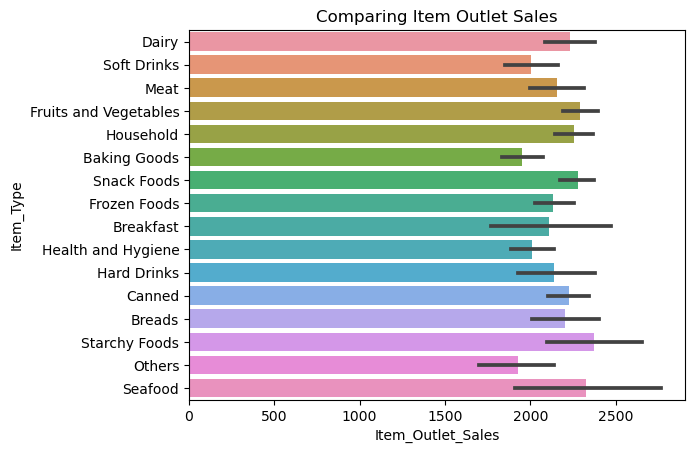

In [116]:
# Comparing the Item Outlet Sales by each Item Type
ax= sns.barplot(data= df, x= 'Item_Outlet_Sales', y= 'Item_Type')
ax.set_title('Comparing Item Outlet Sales');

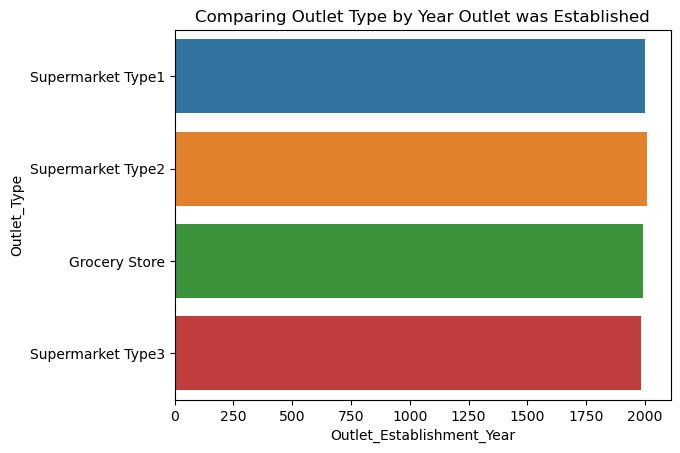

In [117]:
ax= sns.barplot(data=df, x= 'Outlet_Establishment_Year', y= 'Outlet_Type')
ax.set_title('Comparing Outlet Type by Year Outlet was Established');

### Histograms

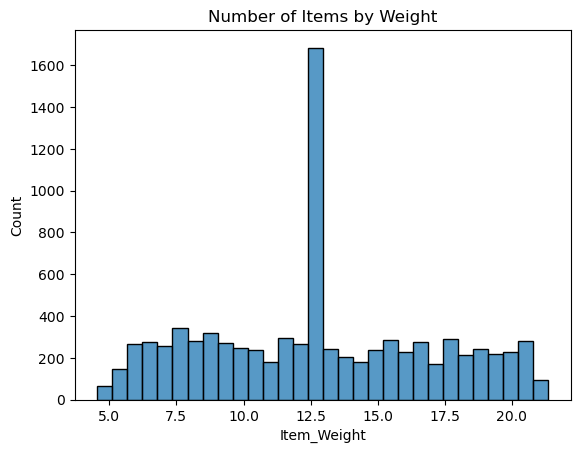

In [118]:
ax = sns.histplot(data= df,
                  x= 'Item_Weight',
                  bins= 30)
ax.set_title('Number of Items by Weight');

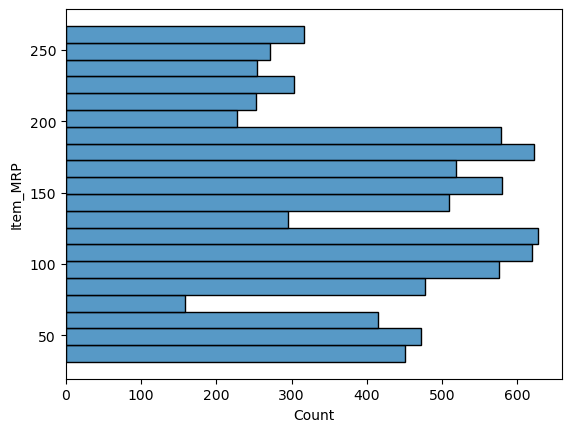

In [119]:
ax = sns.histplot(data=df,
                  y= 'Item_MRP',
                  bins= 20);

### Boxplots

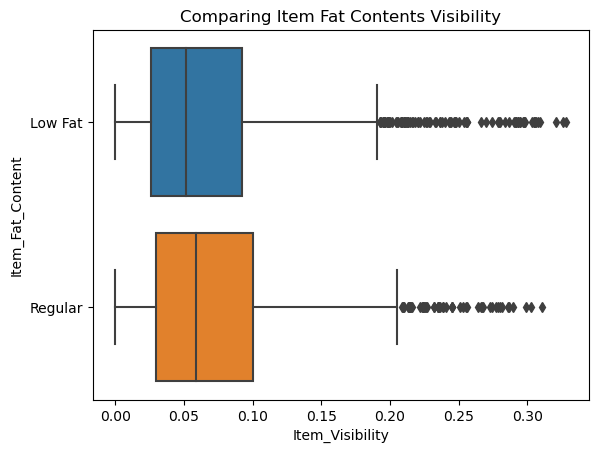

In [120]:
# Comparing the Visibility of Regular vs. Low Fat Content Items using a Boxplot
ax = sns.boxplot(x= 'Item_Visibility', y= 'Item_Fat_Content', data=df)
ax.set_title('Comparing Item Fat Contents Visibility');

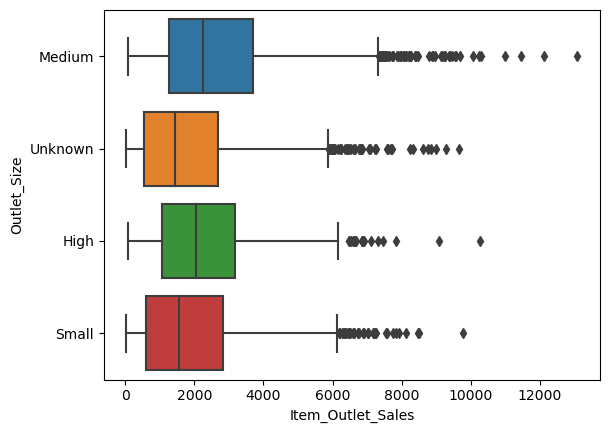

In [121]:
# Comparing the 'Item_Outlet_Sales' by the Outlets size.
ax = sns.boxplot(x= 'Item_Outlet_Sales', y= 'Outlet_Size', data=df)

### Heatmaps

/var/folders/5z/rbhjbxt93x56vw5bldr0n_900000gn/T/ipykernel_51151/2026071504.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap= 'Blues', annot= True);


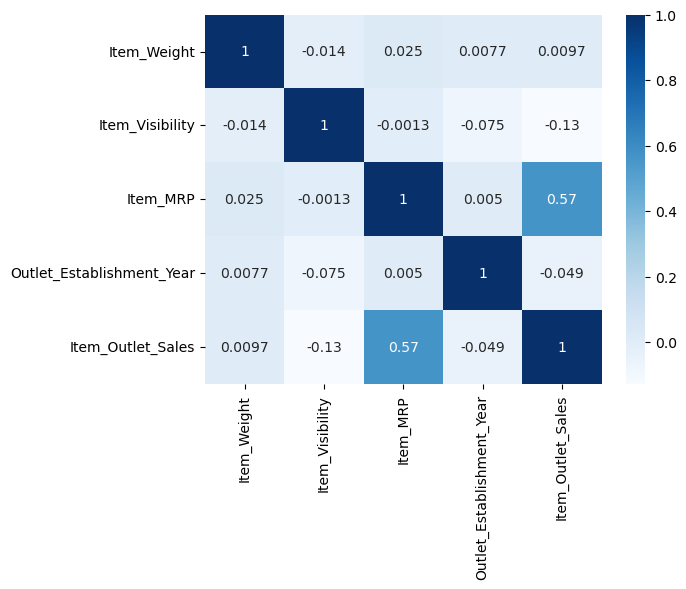

In [122]:
sns.heatmap(df.corr(), cmap= 'Blues', annot= True);

## Explanatory Data Analysis

### Q1: Does visibility of items increase the item outlet sales?

In [123]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Unknown,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


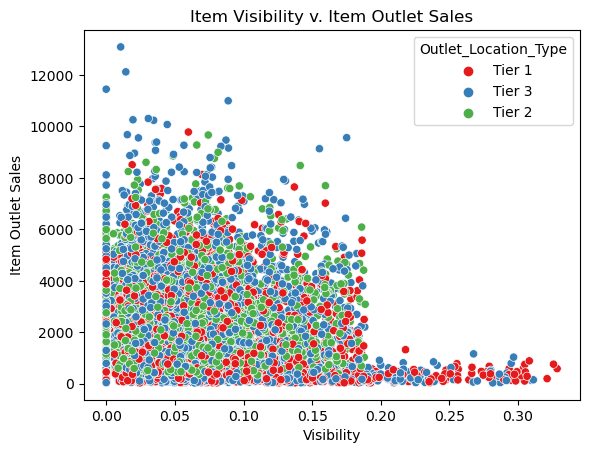

In [124]:
ax= sns.scatterplot(data=df, x='Item_Visibility', y= 'Item_Outlet_Sales', hue= 'Outlet_Location_Type', palette= 'Set1')

ax.set_title('Item Visibility v. Item Outlet Sales')
ax.set_xlabel('Visibility')
ax.set_ylabel('Item Outlet Sales');


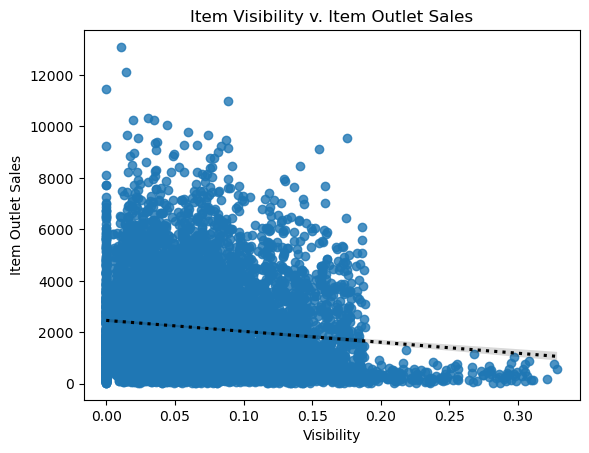

In [125]:
ax= sns.regplot(data=df, x='Item_Visibility', y= 'Item_Outlet_Sales', line_kws= {'color': 'black', 'ls': ':'})

ax.set_title('Item Visibility v. Item Outlet Sales')
ax.set_xlabel('Visibility')
ax.set_ylabel('Item Outlet Sales');

- Item visibility does **not** increase outlet sales.

### Q2: What item type has the highest item outlet sales?

In [126]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Unknown,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


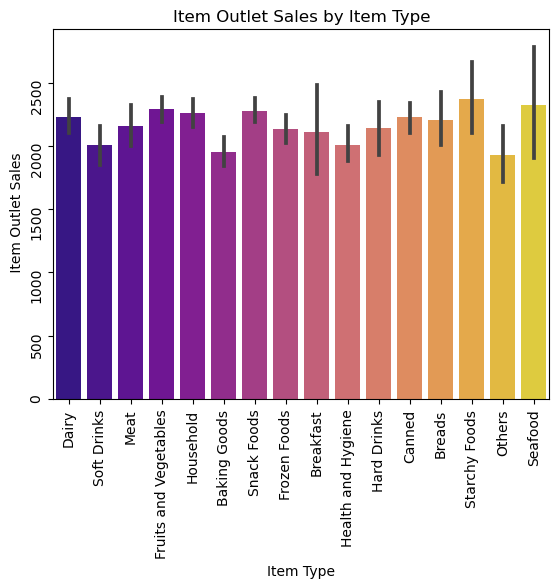

In [127]:

ax= sns.barplot(data= df, x= 'Item_Type', y= 'Item_Outlet_Sales', palette='plasma')

ax.tick_params(rotation = 90)
ax.set_title('Item Outlet Sales by Item Type')
ax.set_xlabel('Item Type')
ax.set_ylabel(' Item Outlet Sales');

- On average, Starchy Food items have the highest item outlet sales. 

## Preprocesing for Machine Learning

### Reloading in the Data

In [128]:
df2 = pd.read_csv('Data/sales_predictions_2023.csv')

#### .head( )

In [129]:
df2.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


#### .info( )

In [130]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### Clean Data

In [131]:
# Duplicates
print(f'There are {df2.duplicated().sum()} duplicates.')

There are 0 duplicates.


In [132]:
df2.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [133]:
# Looking for inconsistent categories of data 
df2['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [134]:
# Fixing the categories of data that have inconsistencies.
df2['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'}, inplace=True)
df2['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [135]:
df2.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

### Defining X and y

- Our target is "Item_Outlet_Sales"

In [136]:
# X and y
target= 'Item_Outlet_Sales'

X = df2.drop(columns= ['Item_Outlet_Sales', 'Item_Identifier'])
y = df2[target]

### Train Test Split

In [137]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= SEED)

In [138]:
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,7.220,Regular,0.064142,Baking Goods,61.2510,OUT010,1998,NaN,Tier 3,Grocery Store
7604,6.135,Low Fat,0.079294,Soft Drinks,111.2860,OUT018,2009,Medium,Tier 3,Supermarket Type2
2762,12.150,Low Fat,0.028593,Household,151.0708,OUT035,2004,Small,Tier 2,Supermarket Type1
6464,5.945,Low Fat,0.093009,Household,127.8652,OUT035,2004,Small,Tier 2,Supermarket Type1
4707,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,OUT035,2004,Small,Tier 2,Supermarket Type1


### Preprocessing + ColumnTransformer


In [139]:
# Selectors
cat_sel = make_column_selector(dtype_include='object')

cat_sel(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [140]:
num_sel= make_column_selector(dtype_include='number')

num_sel(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [141]:
# Pipelines
cat_pipe= make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                       OneHotEncoder(handle_unknown='ignore', sparse=False))

num_pipe= make_pipeline(SimpleImputer(strategy='mean'))

In [142]:
# Preprocessing Column Transformer
preprocessor= make_column_transformer((num_pipe, num_sel),
                                     (cat_pipe, cat_sel),
                                     verbose_feature_names_out=False)
preprocessor


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14632bee0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14716e370>)],
                  verbose_feature_names_out=False)

In [143]:
# Fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names= preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_Low Fat',
       'Item_Fat_Content_Regular', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Identifier_OUT010',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Size_High',
       'Outlet_Size_MISSING', 'Outlet_Size_Medium', 'Outlet_Size_Small',
      

In [145]:
X_train_df= pd.DataFrame(preprocessor.transform(X_train),
                        columns = feature_names, index = X_train.index)
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,7.220,0.064142,61.2510,1998.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7604,6.135,0.079294,111.2860,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2762,12.150,0.028593,151.0708,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6464,5.945,0.093009,127.8652,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4707,18.200,0.066285,247.2092,2004.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [146]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8077,15.250000,0.061531,132.2968,2007.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2391,17.850000,0.044463,127.1020,1997.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
163,7.270000,0.071078,114.2518,1997.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4608,12.822634,0.075142,145.8444,1985.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5544,13.500000,0.121633,161.6920,1998.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [147]:
y_test.head()

8077    1696.4584
2391    2024.0320
163     2618.5914
4608    3773.7544
5544     159.7920
Name: Item_Outlet_Sales, dtype: float64

In [148]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    # Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    # Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

## Linear Regression 

In [149]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.56	RMSE= 1114.98
Test Data:	R^2= 0.56	RMSE= 1164.41


In [150]:
lin_reg.coef_

array([   1.06785557, -276.61155652,   15.60194362,  -14.22042061,
        -15.68829427,   15.68829427,    8.97739258,   -4.09219017,
         69.88439671,   22.60032924,  -48.84338125,   -5.40780071,
         16.17362127,   49.13525181,  -41.49960301,  -68.64200308,
        -15.91206968,   17.60709784,   98.50049025,  -11.70291833,
       -117.85587742,   31.07726395, -420.53817385,  -67.99342481,
        213.17870445,  -87.01125117, -464.15320226,  585.45414205,
         66.8404385 ,  -39.83389775,  301.24207912,  -87.18541427,
        -67.99342481, -247.19336716,  411.25747661,  -96.07068464,
       -250.09653741,  240.18524519,    9.91129222, -884.69137611,
        386.24848523,  -87.01125117,  585.45414205])

In [151]:
# Checking the number of coeffs matches the # of feature names
print(len(lin_reg.coef_))
len(feature_names)

43


43

In [152]:
# Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs

Item_Weight                          1.067856
Item_Visibility                   -276.611557
Item_MRP                            15.601944
Outlet_Establishment_Year          -14.220421
Item_Fat_Content_Low Fat           -15.688294
Item_Fat_Content_Regular            15.688294
Item_Type_Baking Goods               8.977393
Item_Type_Breads                    -4.092190
Item_Type_Breakfast                 69.884397
Item_Type_Canned                    22.600329
Item_Type_Dairy                    -48.843381
Item_Type_Frozen Foods              -5.407801
Item_Type_Fruits and Vegetables     16.173621
Item_Type_Hard Drinks               49.135252
Item_Type_Health and Hygiene       -41.499603
Item_Type_Household                -68.642003
Item_Type_Meat                     -15.912070
Item_Type_Others                    17.607098
Item_Type_Seafood                   98.500490
Item_Type_Snack Foods              -11.702918
Item_Type_Soft Drinks             -117.855877
Item_Type_Starchy Foods           

In [153]:
# add the intercept to series
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                            1.067856
Item_Visibility                     -276.611557
Item_MRP                              15.601944
Outlet_Establishment_Year            -14.220421
Item_Fat_Content_Low Fat             -15.688294
Item_Fat_Content_Regular              15.688294
Item_Type_Baking Goods                 8.977393
Item_Type_Breads                      -4.092190
Item_Type_Breakfast                   69.884397
Item_Type_Canned                      22.600329
Item_Type_Dairy                      -48.843381
Item_Type_Frozen Foods                -5.407801
Item_Type_Fruits and Vegetables       16.173621
Item_Type_Hard Drinks                 49.135252
Item_Type_Health and Hygiene         -41.499603
Item_Type_Household                  -68.642003
Item_Type_Meat                       -15.912070
Item_Type_Others                      17.607098
Item_Type_Seafood                     98.500490
Item_Type_Snack Foods                -11.702918
Item_Type_Soft Drinks               -117

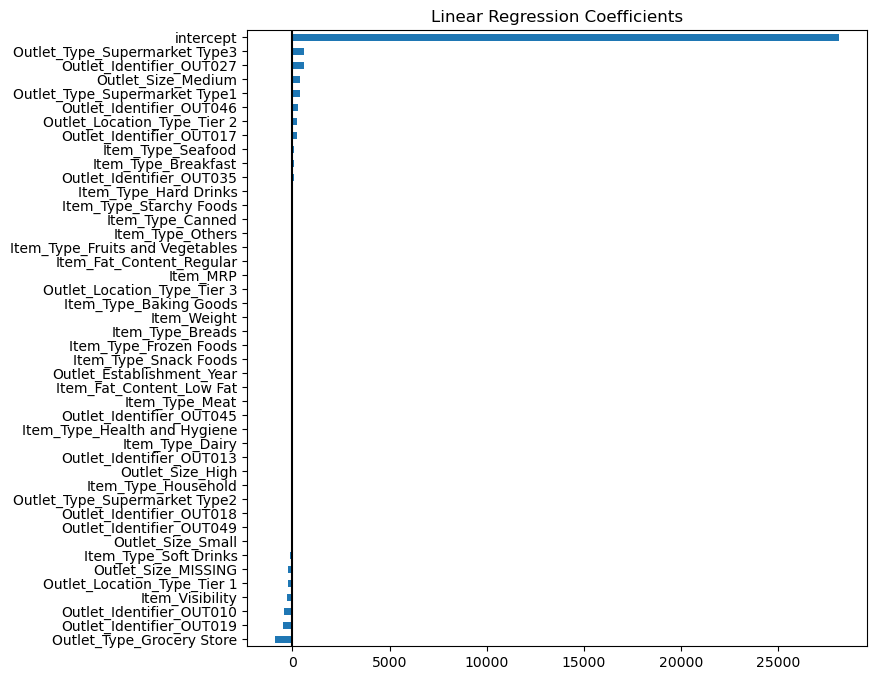

In [156]:
# Plot coefficients
ax = coeffs.sort_values().plot(kind='barh',figsize=(8,8))
ax.axvline(0,color='k')
ax.set_title('Linear Regression Coefficients');

In [157]:
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
coeff_rank

intercept                          44.0
Outlet_Type_Grocery Store          43.0
Outlet_Type_Supermarket Type3      42.0
Outlet_Identifier_OUT027           41.0
Outlet_Identifier_OUT019           40.0
Outlet_Identifier_OUT010           39.0
Outlet_Size_Medium                 38.0
Outlet_Type_Supermarket Type1      37.0
Outlet_Identifier_OUT046           36.0
Item_Visibility                    35.0
Outlet_Location_Type_Tier 1        34.0
Outlet_Size_MISSING                33.0
Outlet_Location_Type_Tier 2        32.0
Outlet_Identifier_OUT017           31.0
Item_Type_Soft Drinks              30.0
Item_Type_Seafood                  29.0
Outlet_Size_Small                  28.0
Outlet_Identifier_OUT049           27.0
Outlet_Identifier_OUT018           26.0
Outlet_Type_Supermarket Type2      25.0
Item_Type_Breakfast                24.0
Item_Type_Household                23.0
Outlet_Size_High                   22.0
Outlet_Identifier_OUT013           21.0
Outlet_Identifier_OUT035           20.0


In [158]:
top_n_features = coeff_rank.head(3)
top_n_features

intercept                        44.0
Outlet_Type_Grocery Store        43.0
Outlet_Type_Supermarket Type3    42.0
dtype: float64

In [159]:
plot_vals = coeffs.loc[top_n_features.index]
plot_vals

intercept                        28131.994151
Outlet_Type_Grocery Store         -884.691376
Outlet_Type_Supermarket Type3      585.454142
dtype: float64

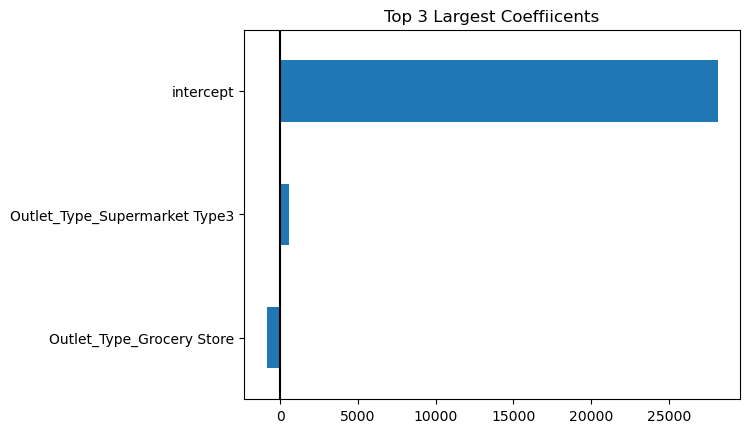

In [160]:
#  Plot the coefficients
top_n= 3
ax = plot_vals.sort_values().plot(kind='barh')
ax.axvline(0,color='k')
ax.set_title(f'Top {top_n} Largest Coeffiicents');


In [169]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=15, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        # sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        # rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    # plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

Training Data:	R^2= 0.56	RMSE= 1114.98
Test Data:	R^2= 0.56	RMSE= 1164.41


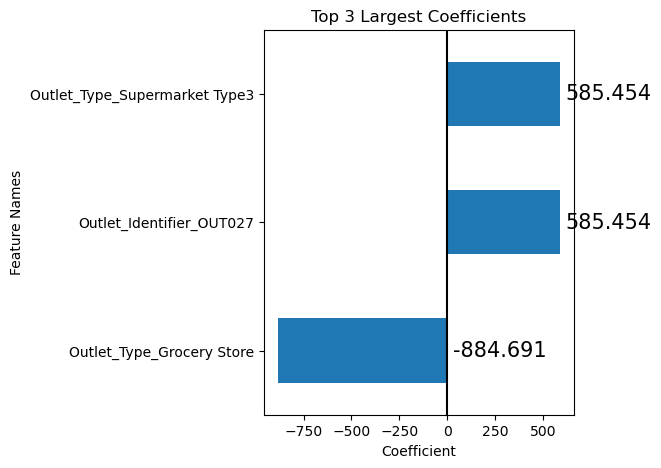

In [170]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)
plot_coeffs(coeffs,top_n=3,annotate=True);

- Coefficients that Positively Influence Final Grade:
    - **Outlet_Type_Supermarket Type3:** Type 3 Supermarkets increase item outlet sales by $585.45. 
    
    - **Outlet_Identifier_OUT027:** OUT027 outlets increases item outlet sales also by $585.45.
    

- Coefficient(s) that Negatively Influence Final Grade:

    - **Outlet_Type_Grocery Store:** Grocery stores decreased item outlet sales by $884.69.
    

## Tree-Based  Model

In [171]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 423.46
Test Data:	R^2= 0.56	RMSE= 1162.86


In [173]:
# Extracting Feature Importances

reg.feature_importances_

array([5.33489702e-02, 9.72414826e-02, 4.44014628e-01, 2.58290321e-02,
       4.81469717e-03, 4.81332374e-03, 4.51038193e-03, 2.93059725e-03,
       2.48789489e-03, 4.37925280e-03, 5.55931979e-03, 5.84720669e-03,
       8.50224810e-03, 3.00266196e-03, 4.20315806e-03, 6.24304128e-03,
       3.62042325e-03, 1.65926807e-03, 1.37602475e-03, 8.14116626e-03,
       4.09239505e-03, 3.05423103e-03, 1.23978559e-05, 1.69685378e-03,
       2.97642063e-03, 1.11887765e-03, 1.15267066e-05, 3.04683859e-02,
       3.73130852e-03, 4.94291351e-03, 2.99626325e-03, 3.24816865e-03,
       1.51603797e-03, 3.14308814e-03, 2.87684299e-03, 4.16682924e-03,
       3.30760670e-03, 2.60565761e-03, 2.55647804e-03, 1.96758190e-01,
       2.05569774e-03, 9.88610816e-04, 2.91504402e-02])

In [174]:
# Checking the number of feature importances matches the # of columns
print(len(reg.feature_importances_))
print(len(X_train_df.columns))
len(reg.feature_importances_) == len(X_train_df.columns)

43
43


True

In [175]:
# Saving the feature importances
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

Item_Weight                        0.053349
Item_Visibility                    0.097241
Item_MRP                           0.444015
Outlet_Establishment_Year          0.025829
Item_Fat_Content_Low Fat           0.004815
Item_Fat_Content_Regular           0.004813
Item_Type_Baking Goods             0.004510
Item_Type_Breads                   0.002931
Item_Type_Breakfast                0.002488
Item_Type_Canned                   0.004379
Item_Type_Dairy                    0.005559
Item_Type_Frozen Foods             0.005847
Item_Type_Fruits and Vegetables    0.008502
Item_Type_Hard Drinks              0.003003
Item_Type_Health and Hygiene       0.004203
Item_Type_Household                0.006243
Item_Type_Meat                     0.003620
Item_Type_Others                   0.001659
Item_Type_Seafood                  0.001376
Item_Type_Snack Foods              0.008141
Item_Type_Soft Drinks              0.004092
Item_Type_Starchy Foods            0.003054
Outlet_Identifier_OUT010        

In [181]:
# Saving the feature importances sorted from smallest to largest

sorted_importance = importances.sort_values()
sorted_importance

Outlet_Identifier_OUT019           0.000012
Outlet_Identifier_OUT010           0.000012
Outlet_Type_Supermarket Type2      0.000989
Outlet_Identifier_OUT018           0.001119
Item_Type_Seafood                  0.001376
Outlet_Size_High                   0.001516
Item_Type_Others                   0.001659
Outlet_Identifier_OUT013           0.001697
Outlet_Type_Supermarket Type1      0.002056
Item_Type_Breakfast                0.002488
Outlet_Location_Type_Tier 3        0.002556
Outlet_Location_Type_Tier 2        0.002606
Outlet_Size_Medium                 0.002877
Item_Type_Breads                   0.002931
Outlet_Identifier_OUT017           0.002976
Outlet_Identifier_OUT046           0.002996
Item_Type_Hard Drinks              0.003003
Item_Type_Starchy Foods            0.003054
Outlet_Size_MISSING                0.003143
Outlet_Identifier_OUT049           0.003248
Outlet_Location_Type_Tier 1        0.003308
Item_Type_Meat                     0.003620
Outlet_Identifier_OUT035        

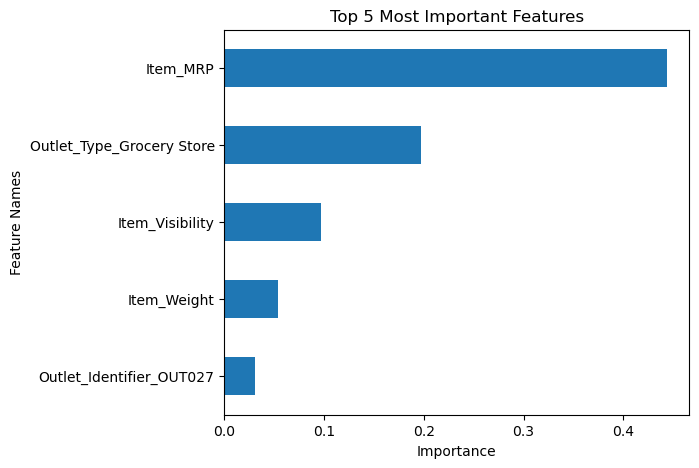

In [185]:
ax= sorted_importance.tail().plot(kind='barh',
                                   figsize=(6,5))

ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 5 Most Important Features');


### What the feature importances tell us:

- Item_MRP is easily the single most important feature for predicting item outlet sales.


## Serialization

In [187]:
export= {'preprocessor': preprocessor,
        'X_train': X_train_df,
        'y_train': y_train,
        'X_test': X_test_df,
        'y_test': y_test,
        'LinearRegression': lin_reg,
        'RandomForest': reg}
joblib.dump(export, 'linereg_and_rf.joblib')

['linereg_and_rf.joblib']